# 준비

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter
from gensim.models import Word2Vec
from transformers import pipeline

In [3]:
# 그래프 한글 출력 설정

from matplotlib import font_manager, rc

# 나눔고딕 폰트 경로 (예: 윈도우 기본 설치 위치)
# Mac, Linux 환경에 따라 경로가 다를 수 있음
font_path = '/Users/intazero/Library/Fonts/NanumBarunGothic.ttf'

# 1. 폰트 등록
font_name = font_manager.FontProperties(fname=font_path).get_name()

# 2. 전역 폰트 설정
rc('font', family=font_name)

In [3]:
NAM_words = pd.read_csv("/Users/intazero/Downloads/Sovereignty-1stROKLegislators/result/NAM_words_Gemini2.5Flash_noRAG_20250620.csv", index_col = 0)
NAM_words

,Key,Phrase,Term,Pos,Definition,sent_id
0,1,반민족행위처벌법,반민족행위처벌법(反民族行爲處罰法),명사,1948년 제헌국회에서 제정된 법률. 일제 강점기 친일 행위자를 처벌하기 위해 만들어졌다,1
1,2,초안,초안(草案),명사,어떤 안건이나 계획 따위를 정식으로 결정하기 전에 미리 작성한 안,1
2,3,1장,1장(章),명사,책이나 글의 내용을 구분하는 단위,1
3,4,죄,죄(罪),명사,법률이나 도덕을 어긴 행위,1
4,5,1조,1조(條),명사,법률이나 규정 따위의 내용을 나누는 단위,1
...,...,...,...,...,...,...
47887,13,보기,보다,동사,눈으로 대상의 존재나 형태적 특징을 알다.,1696
47888,14,주권이,주권(主權),명사,국가의 의사를 최종적으로 결정하는 권력.,1696
47889,15,아니라,아니다,형용사,앞의 내용과 다르거나 틀리다.,1696
47890,16,사실상,사실(事實),명사,실제로 있었던 일이나 현재에 있는 일.,1696


In [ ]:
# 명사 + 접미사 형태를 명사로 변환, 접미사 제거

NAM_words['Term'] = NAM_words['Term'].str.replace(r'-(하다|되다|시키다|답다|드리다|받다|스럽다|지다)$', '', regex=True)
NAM_words

,Key,Phrase,Term,Pos,Definition,sent_id
0,1,반민족행위처벌법,반민족행위처벌법(反民族行爲處罰法),명사,1948년 제헌국회에서 제정된 법률. 일제 강점기 친일 행위자를 처벌하기 위해 만들어졌다,1
1,2,초안,초안(草案),명사,어떤 안건이나 계획 따위를 정식으로 결정하기 전에 미리 작성한 안,1
2,3,1장,1장(章),명사,책이나 글의 내용을 구분하는 단위,1
3,4,죄,죄(罪),명사,법률이나 도덕을 어긴 행위,1
4,5,1조,1조(條),명사,법률이나 규정 따위의 내용을 나누는 단위,1
...,...,...,...,...,...,...
47887,13,보기,보다,동사,눈으로 대상의 존재나 형태적 특징을 알다.,1696
47888,14,주권이,주권(主權),명사,국가의 의사를 최종적으로 결정하는 권력.,1696
47889,15,아니라,아니다,형용사,앞의 내용과 다르거나 틀리다.,1696
47890,16,사실상,사실(事實),명사,실제로 있었던 일이나 현재에 있는 일.,1696


In [ ]:
# 단어 교체

replace_dict = {
    '주권옹호투쟁위원회': '국민주권옹호투쟁위원회',
    '쏘련(蘇聯)': '소련(蘇聯)',
    '오지리' : '오스트리아',
    '오지리(墺地利)' : '오스트리아',
    '유엔(UN)': '유엔'
}

def replace_if_exact(text):
    return replace_dict.get(text, text)

NAM_words['Term'] = NAM_words['Term'].apply(replace_if_exact)

In [6]:
words = NAM_words['Term'].dropna().astype(str)

# 단어 빈도 계산
word_counts = Counter(words)

# 상위 300개 단어 추출
top_300 = word_counts.most_common(300)

# DataFrame으로 변환
top_300_df = pd.DataFrame(top_300, columns=['word', 'count'])
top_300_df.tail(60)

,word,count
240,국토(國土),26
241,간섭(干涉),26
242,개인(個人),26
243,행정권(行政權),26
244,살다,26
245,당시(當時),26
246,수립(樹立),26
247,민의(民意),26
248,조직(組織),26
249,공산당(共産黨),26


In [ ]:
# 불용어 제거

remove_words = ['우리', '하다', '되다', '있다', '대하다', '않다', '보다', '말씀', '생각', '사람', '아니다', '위하다', '말', '같다', '알다', '받다', '일', '사실', '사실(事實)', '말하다', '가다', '의하다', '나가다', '때',
                '오늘날', '점(點)', '필요(必要)', '앞', '들다', '생각(生覺)', '아니하다', '지금', '자리', '이유(理由)', '관(關)', '까닭', '관하다', '동시(同時)', '얘기', '경우(境遇)',
                 '오늘', '마당', '자체(自體)', '통하다', '전체(全體)', '불구(不拘)', '드리다', '이다', '여러분', '지금(只今)', '그러하다', '이야기', '그러다', '이번', '소위(所謂)',
                  '예(例)', '밑', '그렇다', '말미암다', '결국(結局)', '마찬가지', '당시(當時)', '대(對)', '의(依)', '계시다', '전(前)', '뒤', '가운데', '내(內)', '측(側)', '여하간(如何間)', '그동안', '안',
               '이번(이番)', '두다', '금후(今後)', '이외(以外)', '이내(以內)', '그네', '상(上)', '하(下)', '아래', '면(面)', '타면(他面)', '이때', '후(後)', '아까', '각위(各位)', '금년(今年)', '최근(最近)', '하등(何等)', '금일(今日)', 
                '이래(以來)', '포함(包含)', '오후(午後)', '오전(午前)', '만약(萬若)', '한편(한便)', '한편', '한편(一方)', '만일(萬一)', '금반(今般)', '금번(今番)', '단기(檀紀)', '단기', '말미암다', '환언(換言)', '종래(從來)', '명년(明年)',
               '금차(今次)', '모양', '모양(模樣)', '위시(爲始)', '어제', '내일(來日)', '매년(每年)', '내년(來年)', '작년(昨年)', '재작년(再昨年)', '년(年)', '그때', '그다음', '오늘날(今日)', '수(誰)', '나중', '그날', '다음', '바깥', '근래(近來)', '피차(彼此)',
               '건(件)', '좌기(左記)', '우기(右記)', '상기(上記)', '엊그제', '어저께', '동안', '여하(如何)', '만하다', '운운(云云)', '당일(當日)', '동(同)', '해(該)', '각(各)', '이러하다', '관련(關聯)', '정도(程度)', '관하(關下)', '의하(依下)', '귀(貴)',
               '예하(隸下)', '즉시(卽時)', '설명(說明)', '드리다', '시키다', '목하(目下)', '당면(當面)', '직후(直後)', '직전(直前)', '전후(前後)', '격(格)', '당(當)', '외(外)', '어떠하다', '물론(勿論)', '금월(今月)', '각종(各種)', '인(因)',
               '사이', '일절(一切)', '일종(一種)', '일체(一切)', '목전(目前)', '비롯', '일시(一時)', '이상(以上)', '이하(以下)', '운위(云謂)', '여지(餘地)', '생각하다', '점차(漸次)', '이즈음', '등등(等等)', '의미(意味)', '뜻', '저번', '저번(這番)', '개별(個別)',
                '나다', '목적(目的)', '누차(屢次)', '장내(場內)', '소연(騷然)', '내용(內容)', '소재(所在)', '부득이(不得已)', '하루', '현하(現下)', '현재(現在)', '사전(事前)', '사후(事後)', '나변(那邊)', '차제(此際)', '일전(日前)', '이전(以前)', '각각(各各)',
               '요전', '요전번', '요전 날', '요전(綠前)', '요전(料前)']
NAM_words_cleaned = NAM_words[~NAM_words['Term'].isin(remove_words)]

NAM_words_cleaned

,Key,Phrase,Term,Pos,Definition,sent_id
0,1,반민족행위처벌법,반민족행위처벌법(反民族行爲處罰法),명사,1948년 제헌국회에서 제정된 법률. 일제 강점기 친일 행위자를 처벌하기 위해 만들어졌다,1
1,2,초안,초안(草案),명사,어떤 안건이나 계획 따위를 정식으로 결정하기 전에 미리 작성한 안,1
2,3,1장,1장(章),명사,책이나 글의 내용을 구분하는 단위,1
3,4,죄,죄(罪),명사,법률이나 도덕을 어긴 행위,1
4,5,1조,1조(條),명사,법률이나 규정 따위의 내용을 나누는 단위,1
...,...,...,...,...,...,...
47884,10,사법부에,사법부(司法府),명사,법률을 해석하고 적용하여 분쟁을 해결하는 국가 기관.,1696
47885,11,견제력을,견제력(牽制力),명사,상대편을 억눌러 더 이상 나아가지 못하게 하는 힘.,1696
47886,12,가진다고,가지다,동사,자기 것으로 하다.,1696
47888,14,주권이,주권(主權),명사,국가의 의사를 최종적으로 결정하는 권력.,1696


# Sentiment Analysis - 전체

In [2]:
sentiment_a = pd.read_csv("/Users/intazero/Downloads/Sovereignty-1stROKLegislators/NAM_sentences_final.csv", index_col=0)
sentiment_a

,회의번호,대수,회의구분,회수,차수,회의연도,안건,발언자,발언순번,sent_raw,sent_id
96,41,1,본회의,제1회,제41차,1948,개의,의사국장 차윤홍,8,반민족행위처벌법(초안) 제1장 죄 제1조 일본 정부와 통모하여 한일합병에 적극 협력...,1
97,41,1,본회의,제1회,제41차,1948,5. 사면법안,법무부차관 권승열,126,그래서 이 사면법은 대체로 그 주권자에 대한 적용이올시다.,2
98,41,1,본회의,제1회,제41차,1948,5. 사면법안,법무부차관 권승열,126,즉 주권이 인민에게 있는 까닭으로 국회가 주권을 가지고 있고 그 권한행사를 법률로서...,3
99,41,1,본회의,제1회,제41차,1948,5. 사면법안,법무부차관 권승열,126,그런데 일본 같은 나라에서는 소위 천황이 대권작용이라고 해서 헌법에 제한하지 않는 ...,4
100,43,1,본회의,제1회,제43차,1948,2. 반민족행위처벌법안,윤재욱 의원,41,그런데 헌법 제4조를 보면 대한민국의 주권은 국민에게 있고 모든 권력은 국민으로부터...,5
...,...,...,...,...,...,...,...,...,...,...,...
1914,1848,4,본회의,제35회,제22차,1960,―국가보안법 개정법률안 제1독회―(상오 11시31분),국가보안법개정안기초위원장 조재천,20,"왜 그러냐 하면 이 내란죄는 국토의 참절이라고 했는데, 즉 그것은 영토, 주권 일부...",1692
1916,1857,4,본회의,제35회,제31차,1960,―국회의원선거법안 제1독회―(상오 11시25분),이재형 의원,22,군인이라 하더라도 또 원주지를 떠나서 일정한 주소가 없이 돌아다니는 사람이라 하더라...,1693
1917,1858,4,본회의,제35회,제32차,1960,―경찰법안 제1독회―(상오 11시4분),경찰중립화법안기초위원장 김선태,14,그런데 이 총결산된 이 대통령의 12년간의 치적이라고 하는 그것은 무엇이 근원이 되...,1694
1918,1860,4,본회의,제35회,제34차,1960,―헌법 개정안―,주요한 의원,8,4월혁명이라고 하는 것은 그 당면한 목표가 잃어버렸던 주권을 찾고 짓밟힌 자유와 권...,1695


In [3]:
# 감성 분석 AI 모델 불러오기
pipe = pipeline("text-classification", model="searle-j/kote_for_easygoing_people", truncation = True)

Device set to use mps:0


In [6]:
labels = []

for idx, row in sentiment_a.iterrows():
    sentence = row['sent_raw']
    result = pipe(sentence)
    label = result[0]['label']  # 첫 번째 결과의 label만 사용
    labels.append(label)

sentiment_a['sentiment'] = labels

In [12]:
set(labels)

{'감동/감탄',
 '기대감',
 '깨달음',
 '놀람',
 '불쌍함/연민',
 '불안/걱정',
 '불평/불만',
 '비장함',
 '슬픔',
 '안심/신뢰',
 '안타까움/실망',
 '어이없음',
 '없음',
 '의심/불신',
 '존경',
 '짜증',
 '한심함',
 '화남/분노'}

In [20]:
'''
중립 - 비장함, 깨달음, 놀람, 
부정 - 안타까움/실망, 의심/불신, 화남/분노, 불안/걱정, 불평/불만, 어이없음, 짜증, 슬픔, 한심함, 불쌍함/연민
긍정 - 기대감, 안심/신뢰, 감동/감탄, 존경
'''

'\n중립 - 비장함,깨달음, 놀람, \n부정 - 안타까움/실망, 의심/불신, 화남/분노, 불안/걱정, 불평/불만, 어이없음, 짜증, 슬픔, 한심함, 불쌍함/연민\n긍정 - 기대감,안심/신뢰, 감동/감탄, 존경\n'

In [21]:
# 긍정/부정/중립 (KOTE 논문 참조)
neutral_labels = ['비장함', '깨달음', '놀람']
negative_labels = ['안타까움/실망', '의심/불신', '화남/분노', '불안/걱정', 
                   '불평/불만', '어이없음', '짜증', '슬픔', '한심함', '불쌍함/연민']
positive_labels = ['기대감', '안심/신뢰', '감동/감탄', '존경']

In [ ]:
# 연도 필터링
sentiment_a_1954 = sentiment_a[sentiment_a['회의연도'] <= 1954]
sentiment_a_1960 = sentiment_a[(sentiment_a['회의연도'] >= 1955) & (sentiment_a['회의연도'] <= 1960)]

In [ ]:
# 감성 대분류별, 시기별 누적 막대그래프

from bokeh.palettes import Blues5, Purples5, Reds9
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool, LabelSet, Range1d
from bokeh.layouts import row
import random

output_notebook()

# ==== 감정 레이블 분류 ====
neutral_labels = ['비장함', '깨달음', '놀람']
negative_labels = ['안타까움/실망', '의심/불신', '화남/분노', '불안/걱정', 
                   '불평/불만', '어이없음', '짜증', '슬픔', '한심함', '불쌍함/연민']
positive_labels = ['기대감', '안심/신뢰', '감동/감탄', '존경']

def classify_category(sent):
    if sent in positive_labels:
        return '긍정'
    elif sent in negative_labels:
        return '부정'
    elif sent in neutral_labels:
        return '중립'
    else:
        return '없음'

# ==== 고정 색상 매핑 (1948~1954 기준) ====
color_map = {}
blues = Blues5 if len(positive_labels) <= 5 else random.sample(Blues5 * 2, len(positive_labels))
purples = Purples5 if len(neutral_labels) <= 5 else random.sample(Purples5 * 2, len(neutral_labels))
reds = Reds9 if len(negative_labels) <= 9 else random.sample(Reds9 * 2, len(negative_labels))

for label, color in zip(positive_labels, blues):
    color_map[label] = color
for label, color in zip(neutral_labels, purples):
    color_map[label] = color
for label, color in zip(negative_labels, reds):
    color_map[label] = color

default_color = "#000000"
emotion_labels = positive_labels + neutral_labels + negative_labels

# ==== 공통 그래프 함수 ====
def create_sentiment_plot(df, title, y_range):
    df['category'] = df['sentiment'].apply(classify_category)
    pivot_df = df.pivot_table(index='category', columns='sentiment', aggfunc='size', fill_value=0)
    pivot_df = pivot_df.reindex(index=['긍정', '중립', '부정', '없음'])

    etc_labels = [label for label in pivot_df.columns if label not in emotion_labels]
    full_labels = emotion_labels + etc_labels
    colors = [color_map.get(label, default_color) for label in full_labels]

    total_per_category = pivot_df.sum(axis=1)
    total_all = total_per_category.sum()

    source = ColumnDataSource(data=pivot_df)

    p = figure(
        x_range=pivot_df.index.tolist(),
        y_range=y_range,
        height=800, width=600,
        title=title,
        toolbar_location=None, tools=""
    )

    renderers = p.vbar_stack(full_labels, x='category', width=0.3,
                             color=colors, source=source, legend_label=full_labels)

    for label, r in zip(full_labels, renderers):
        hover = HoverTool(
            renderers=[r],
            tooltips=[
                ("감정", label),
                ("대분류", "@category"),
                ("문장 수", f"@{{{label}}}")
            ]
        )
        p.add_tools(hover)

    # 레이블 표시
    label_data = {
        'x': [],
        'y': [],
        'text': []
    }
    for category in pivot_df.index:
        total = total_per_category[category]
        percentage = (total / total_all) * 100 if total_all > 0 else 0
        label_data['x'].append(category)
        label_data['y'].append(total + 5)
        label_data['text'].append(f"{total} ({percentage:.1f}%)")

    label_source = ColumnDataSource(data=label_data)
    label_set = LabelSet(x='x', y='y', text='text', level='glyph',
                         x_offset=0, y_offset=0, source=label_source,
                         text_align='center', text_baseline='bottom', text_font_size="10pt")
    p.add_layout(label_set)

    p.xgrid.grid_line_color = None
    p.axis.minor_tick_line_color = None
    p.legend.location = "top_left"
    p.legend.label_text_font_size = "9pt"
    p.xaxis.axis_label = "감성 대분류"
    p.yaxis.axis_label = "문장 수"

    return p

# ==== y축 공유 범위 계산 ====
max1 = sentiment_a_1954['sentiment'].apply(classify_category).value_counts().max()
max2 = sentiment_a_1960['sentiment'].apply(classify_category).value_counts().max()
shared_y_range = Range1d(start=0, end=max(max1, max2) * 1.2)

# ==== 두 그래프 생성 및 출력 ====
p1 = create_sentiment_plot(sentiment_a_1954.copy(), "감성 대분류별 문장 수 (1948~1954)", y_range=shared_y_range)
p2 = create_sentiment_plot(sentiment_a_1960.copy(), "감성 대분류별 문장 수 (1955~1960)", y_range=shared_y_range)

p2.legend.visible = False

show(row(p1, p2))


Loading BokehJS ...

# Word2Vec - 주권, 국권 비교

In [ ]:
# 문장별로 단어 모으기
word_list = NAM_words_cleaned.groupby('sent_id')['Term'].apply(list).tolist()
word_list

In [8]:
word_list_1954 = word_list[0:1040]
word_list_1960 = word_list[1041:1695]

In [ ]:
# 전기(1948~1954) '주권', '국권' 유사도 분석 (모델 100회 학습)
similarities_1954 = []

for i in range(100):
    model = Word2Vec(
        sentences=word_list_1954,
        vector_size=300,
        window=3,
        min_count=3,
        hs=1,
        sg=1,
        seed=42
    )

    sim = model.wv.similarity("주권(主權)", "국권(國權)")
    similarities_1954.append(sim)

df_1954 = pd.DataFrame({
    'run': range(1, 101),
    'similarity': similarities_1954
})

In [ ]:
# 후기(1955~1960) '주권', '국권' 유사도 분석 (모델 100회 학습)
similarities_1960 = []

for i in range(100):
    model = Word2Vec(
        sentences=word_list_1960,
        vector_size=300,
        window=3,
        min_count=3,
        hs=1,
        sg=1,
        seed=42
    )

    sim = model.wv.similarity("주권(主權)", "국권(國權)")
    similarities_1960.append(sim)

df_1960 = pd.DataFrame({
    'run': range(1, 101),
    'similarity': similarities_1960
})

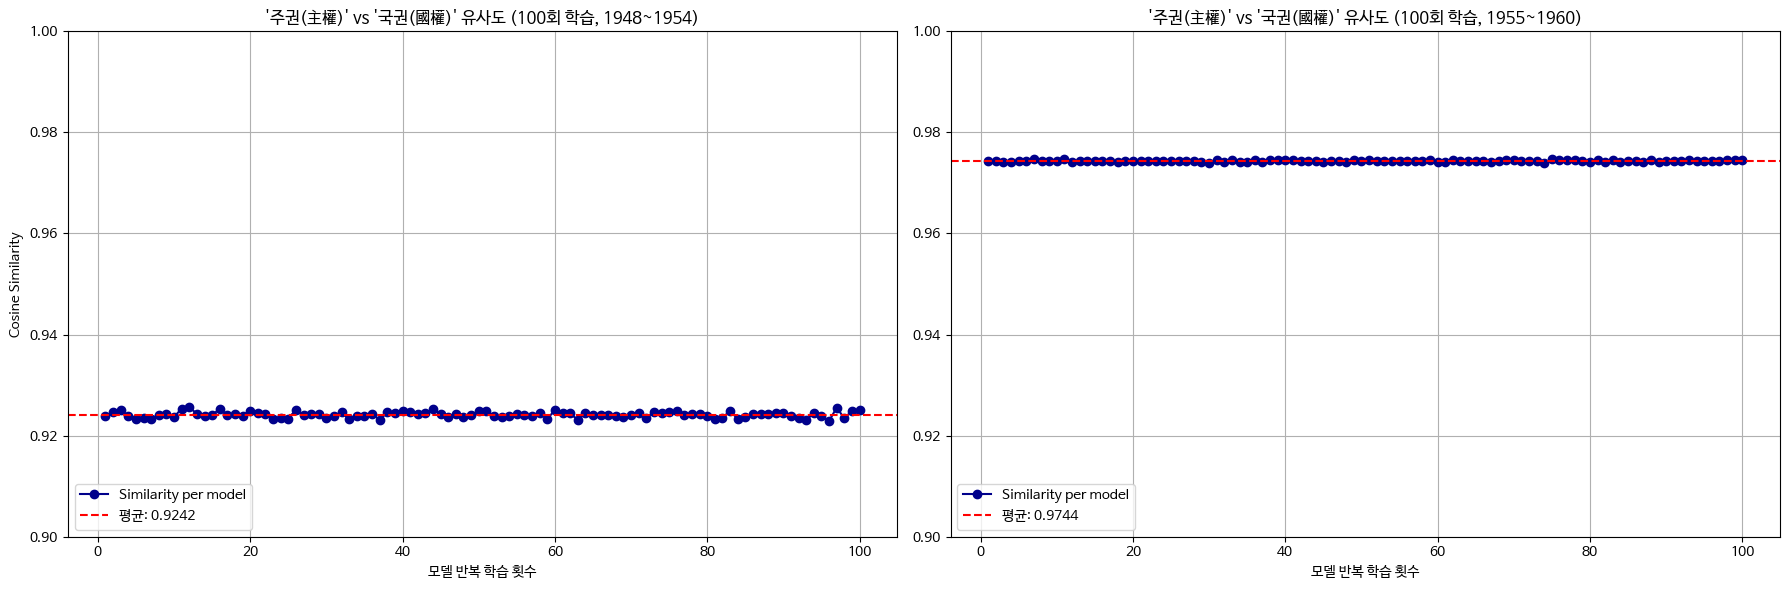

In [ ]:
# 시기별 유사도 그래프

x = list(range(1, 101))

# === 두 그래프를 나란히 배치 ===
fig, axes = plt.subplots(ncols=2, figsize=(18, 6), sharey=True)

# === 왼쪽: 1948~1954 ===
y1 = similarities_1954
axes[0].plot(x, y1, marker='o', linestyle='-', color='darkblue', label='Similarity per model')
axes[0].axhline(np.nanmean(y1), color='red', linestyle='--', label=f'평균: {np.nanmean(y1):.4f}')
axes[0].set_ylim(0.8, 1)
axes[0].set_xlabel("모델 반복 학습 횟수")
axes[0].set_ylabel("Cosine Similarity")
axes[0].set_title("'주권(主權)' vs '국권(國權)' 유사도 (100회 학습, 1948~1954)")
axes[0].grid(True)
axes[0].legend(loc='lower left')

# === 오른쪽: 1955~1960 ===
y2 = similarities_1960
axes[1].plot(x, y2, marker='o', linestyle='-', color='darkblue', label='Similarity per model')
axes[1].axhline(np.nanmean(y2), color='red', linestyle='--', label=f'평균: {np.nanmean(y2):.4f}')
axes[1].set_ylim(0.9, 1)
axes[1].set_xlabel("모델 반복 학습 횟수")
axes[1].set_title("'주권(主權)' vs '국권(國權)' 유사도 (100회 학습, 1955~1960)")
axes[1].grid(True)
axes[1].legend(loc='lower left')

# === 오른쪽 서브플롯의 y축 라벨 강제로 표시 ===
axes[1].yaxis.set_tick_params(labelleft=True)

plt.tight_layout()
plt.show()

# 공기어 연결망

In [10]:
wordsforgraph = pd.DataFrame(NAM_words_cleaned.groupby('sent_id')['Term'].apply(list))
wordsforgraph

,Term
sent_id,
1,"[반민족행위처벌법(反民族行爲處罰法), 초안(草案), 1장(章), 죄(罪), 1조(條..."
2,"[사면법(赦免法), 주권자(主權者), 적용(適用)]"
3,"[주권(主權), 인민(人民), 국회(國會), 주권(主權), 가지다, 권한(權限), ..."
4,"[일본(日本), 나라, 천황(天皇), 대권(大權), 작용(作用), 헌법(憲法), 제..."
5,"[헌법(憲法), 제4조(條), 대한민국(大韓民國), 주권(主權), 국민(國民), 권..."
...,...
1692,"[내란(內亂), 죄(罪), 국토(國土), 참절(斬截), 영토(領土), 주권(主權),..."
1693,"[군인(軍人), 원주지(原住地), 떠나다, 주소(住所), 돌아다니다, 국민(國民),..."
1694,"[총결산(總決算), 대통령(大統領), 12년(年), 치적(治績), 근원(根源), 국..."


In [13]:
NAM_final =  pd.read_csv("/Users/intazero/Downloads/Sovereignty-1stROKLegislators/NAM_sentences_final.csv", index_col = 0)
NAM_final

,회의번호,대수,회의구분,회수,차수,회의연도,안건,발언자,발언순번,sent_raw,sent_id
96,41,1,본회의,제1회,제41차,1948,개의,의사국장 차윤홍,8,반민족행위처벌법(초안) 제1장 죄 제1조 일본 정부와 통모하여 한일합병에 적극 협력...,1
97,41,1,본회의,제1회,제41차,1948,5. 사면법안,법무부차관 권승열,126,그래서 이 사면법은 대체로 그 주권자에 대한 적용이올시다.,2
98,41,1,본회의,제1회,제41차,1948,5. 사면법안,법무부차관 권승열,126,즉 주권이 인민에게 있는 까닭으로 국회가 주권을 가지고 있고 그 권한행사를 법률로서...,3
99,41,1,본회의,제1회,제41차,1948,5. 사면법안,법무부차관 권승열,126,그런데 일본 같은 나라에서는 소위 천황이 대권작용이라고 해서 헌법에 제한하지 않는 ...,4
100,43,1,본회의,제1회,제43차,1948,2. 반민족행위처벌법안,윤재욱 의원,41,그런데 헌법 제4조를 보면 대한민국의 주권은 국민에게 있고 모든 권력은 국민으로부터...,5
...,...,...,...,...,...,...,...,...,...,...,...
1914,1848,4,본회의,제35회,제22차,1960,―국가보안법 개정법률안 제1독회―(상오 11시31분),국가보안법개정안기초위원장 조재천,20,"왜 그러냐 하면 이 내란죄는 국토의 참절이라고 했는데, 즉 그것은 영토, 주권 일부...",1692
1916,1857,4,본회의,제35회,제31차,1960,―국회의원선거법안 제1독회―(상오 11시25분),이재형 의원,22,군인이라 하더라도 또 원주지를 떠나서 일정한 주소가 없이 돌아다니는 사람이라 하더라...,1693
1917,1858,4,본회의,제35회,제32차,1960,―경찰법안 제1독회―(상오 11시4분),경찰중립화법안기초위원장 김선태,14,그런데 이 총결산된 이 대통령의 12년간의 치적이라고 하는 그것은 무엇이 근원이 되...,1694
1918,1860,4,본회의,제35회,제34차,1960,―헌법 개정안―,주요한 의원,8,4월혁명이라고 하는 것은 그 당면한 목표가 잃어버렸던 주권을 찾고 짓밟힌 자유와 권...,1695


In [14]:
wordsforgraph = wordsforgraph.merge(NAM_final[['sent_id', '회의연도']], on='sent_id', how='left')
wordsforgraph = wordsforgraph.rename(columns = {"회의연도" : "year"})
wordsforgraph

,sent_id,Term,year
0,1,"[반민족행위처벌법(反民族行爲處罰法), 초안(草案), 1장(章), 죄(罪), 1조(條...",1948
1,2,"[사면법(赦免法), 주권자(主權者), 적용(適用)]",1948
2,3,"[주권(主權), 인민(人民), 국회(國會), 주권(主權), 가지다, 권한(權限), ...",1948
3,4,"[일본(日本), 나라, 천황(天皇), 대권(大權), 작용(作用), 헌법(憲法), 제...",1948
4,5,"[헌법(憲法), 제4조(條), 대한민국(大韓民國), 주권(主權), 국민(國民), 권...",1948
...,...,...,...
1691,1692,"[내란(內亂), 죄(罪), 국토(國土), 참절(斬截), 영토(領土), 주권(主權),...",1960
1692,1693,"[군인(軍人), 원주지(原住地), 떠나다, 주소(住所), 돌아다니다, 국민(國民),...",1960
1693,1694,"[총결산(總決算), 대통령(大統領), 12년(年), 치적(治績), 근원(根源), 국...",1960
1694,1695,"[4월혁명(四月革命), 목표(目標), 잃어버리다, 주권(主權), 찾다, 짓밟히다, ...",1960


In [15]:
wordsforgraph['doc_no'] = range(len(wordsforgraph))
wordsforgraph

,sent_id,Term,year,doc_no
0,1,"[반민족행위처벌법(反民族行爲處罰法), 초안(草案), 1장(章), 죄(罪), 1조(條...",1948,0
1,2,"[사면법(赦免法), 주권자(主權者), 적용(適用)]",1948,1
2,3,"[주권(主權), 인민(人民), 국회(國會), 주권(主權), 가지다, 권한(權限), ...",1948,2
3,4,"[일본(日本), 나라, 천황(天皇), 대권(大權), 작용(作用), 헌법(憲法), 제...",1948,3
4,5,"[헌법(憲法), 제4조(條), 대한민국(大韓民國), 주권(主權), 국민(國民), 권...",1948,4
...,...,...,...,...
1691,1692,"[내란(內亂), 죄(罪), 국토(國土), 참절(斬截), 영토(領土), 주권(主權),...",1960,1691
1692,1693,"[군인(軍人), 원주지(原住地), 떠나다, 주소(住所), 돌아다니다, 국민(國民),...",1960,1692
1693,1694,"[총결산(總決算), 대통령(大統領), 12년(年), 치적(治績), 근원(根源), 국...",1960,1693
1694,1695,"[4월혁명(四月革命), 목표(目標), 잃어버리다, 주권(主權), 찾다, 짓밟히다, ...",1960,1694


In [17]:
wordsforgraph = wordsforgraph.explode('Term')
wordsforgraph = wordsforgraph.rename(columns = {'Term' : 'word'})
wordsforgraph

,sent_id,word,year,doc_no
0,1,반민족행위처벌법(反民族行爲處罰法),1948,0
0,1,초안(草案),1948,0
0,1,1장(章),1948,0
0,1,죄(罪),1948,0
0,1,1조(條),1948,0
...,...,...,...,...
1695,1696,사법부(司法府),1960,1695
1695,1696,견제력(牽制力),1960,1695
1695,1696,가지다,1960,1695
1695,1696,주권(主權),1960,1695


In [19]:
# 전기 - 1948~1954년
wordsforgraph_1p = wordsforgraph[wordsforgraph['year'] <= 1954]
wordsforgraph_1p

,sent_id,word,year,doc_no
0,1,반민족행위처벌법(反民族行爲處罰法),1948,0
0,1,초안(草案),1948,0
0,1,1장(章),1948,0
0,1,죄(罪),1948,0
0,1,1조(條),1948,0
...,...,...,...,...
1040,1041,작란(作亂),1954,1040
1040,1041,법(法),1954,1040
1040,1041,처단(處斷),1954,1040
1040,1041,반역(叛逆),1954,1040


In [ ]:
# 후기 - 1955~1960년
wordsforgraph_2p = wordsforgraph[(wordsforgraph['year'] >= 1955) & (wordsforgraph['year'] <= 1960)]
wordsforgraph_2p

,sent_id,word,year,doc_no
1041,1042,국제(國際),1955,1041
1041,1042,한일회담(韓日會談),1955,1041
1041,1042,대표(代表),1955,1041
1041,1042,일본(日本),1955,1041
1041,1042,왜놈,1955,1041
...,...,...,...,...
1695,1696,사법부(司法府),1960,1695
1695,1696,견제력(牽制力),1960,1695
1695,1696,가지다,1960,1695
1695,1696,주권(主權),1960,1695


In [22]:
# 전기 단어 연결망을 위한 파일
nm_1p = wordsforgraph_1p[['doc_no', 'word']]
nm_1p

,doc_no,word
0,0,반민족행위처벌법(反民族行爲處罰法)
0,0,초안(草案)
0,0,1장(章)
0,0,죄(罪)
0,0,1조(條)
...,...,...
1040,1040,작란(作亂)
1040,1040,법(法)
1040,1040,처단(處斷)
1040,1040,반역(叛逆)


In [23]:
df100 = nm_1p['word'].value_counts().head(100)
df100_df = pd.DataFrame(df100).reset_index()
df100_df.columns = ['word', 'freq']
df100_df

,word,freq
0,주권(主權),974
1,가지다,492
2,대한민국(大韓民國),321
3,국민(國民),318
4,국가(國家),290
...,...,...
95,과거(過去),25
96,보호(保護),25
97,주권재민(主權在民),24
98,놓다,24


In [24]:
df100_nm = pd.merge(df100_df, nm_1p, on = 'word', how = 'inner')
df100_nm_1 = df100_nm[['doc_no', 'word']]
df100_nm_1

,doc_no,word
0,0,주권(主權)
1,2,주권(主權)
2,2,주권(主權)
3,3,주권(主權)
4,4,주권(主權)
...,...,...
7830,1018,국민투표제(國民投票制)
7831,1018,국민투표제(國民投票制)
7832,1018,국민투표제(國民投票制)
7833,1025,국민투표제(國民投票制)


In [25]:
len(df100_nm_1['word'].unique())

100

In [30]:
df100_nm_1.to_excel("/Users/intazero/Downloads/Sovereignty-1stROKLegislators/wordsforgraph_1p.xlsx", header = None, index = False)

In [31]:
# 후기 단어 연결망을 위한 파일
nm_2p = wordsforgraph_2p[['doc_no', 'word']]
nm_2p

,doc_no,word
1041,1041,국제(國際)
1041,1041,한일회담(韓日會談)
1041,1041,대표(代表)
1041,1041,일본(日本)
1041,1041,왜놈
...,...,...
1695,1695,사법부(司法府)
1695,1695,견제력(牽制力)
1695,1695,가지다
1695,1695,주권(主權)


In [32]:
df100 = nm_2p['word'].value_counts().head(100)
df100_df = pd.DataFrame(df100).reset_index()
df100_df.columns = ['word', 'freq']
df100_df

,word,freq
0,주권(主權),579
1,가지다,444
2,국민(國民),409
3,대한민국(大韓民國),237
4,없다,214
...,...,...
95,지적(指摘),18
96,방해(妨害),18
97,외교(外交),17
98,옹호(擁護),17


In [33]:
df100_nm = pd.merge(df100_df, nm_2p, on = 'word', how = 'inner')
df100_nm_2 = df100_nm[['doc_no', 'word']]
df100_nm_2

,doc_no,word
0,1043,주권(主權)
1,1044,주권(主權)
2,1046,주권(主權)
3,1046,주권(主權)
4,1047,주권(主權)
...,...,...
5736,1503,의장(議長)
5737,1548,의장(議長)
5738,1548,의장(議長)
5739,1552,의장(議長)


In [34]:
len(df100_nm_2['word'].unique())

100

In [35]:
df100_nm_2.to_excel("/Users/intazero/Downloads/Sovereignty-1stROKLegislators/wordsforgraph_2p.xlsx", header = None, index = False)